# Time Series Prediction with Knowledge Based Deep Learning ($KDL$)



AUTHOR: Anurag Dutta (anuragdutta.research@gmail.com)

SUPERVISOR: Tanujit Chakraborty (tanujit.chakraborty@sorbonne.ae)

CREATED: 2023-03-13 17:25:44

## Gathering Dependencies

_Importing Required Libraries_

In [1]:
pip install hampel

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\Users\Anurag Dutta\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip' command.


In [2]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import keras
import tensorflow as tf
from hampel import hampel
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

## Loading Datasets

_TURKEY EARTHQUAKE_

In [3]:
data = pd.read_csv("datasets/eq.csv")
training_set = data.iloc[:, 4]
print(training_set)

0       4.4
1       5.2
2       4.8
3       4.4
4       5.7
       ... 
6569    4.5
6570    4.0
6571    4.4
6572    4.1
6573    4.0
Name: Magnitude, Length: 6574, dtype: float64


In [4]:
t_diff = 1 # Daily Data
print(training_set.max())
gradient_t = (training_set.diff()/t_diff).iloc[1:]
print(gradient_t)
gradient_tt = (gradient_t.diff()/t_diff).iloc[1:]
print(gradient_tt)

7.9
1       0.8
2      -0.4
3      -0.4
4       1.3
5      -1.4
       ... 
6569    0.4
6570   -0.5
6571    0.4
6572   -0.3
6573   -0.1
Name: Magnitude, Length: 6573, dtype: float64
2      -1.200000e+00
3       8.881784e-16
4       1.700000e+00
5      -2.700000e+00
6       1.100000e+00
            ...     
6569    1.500000e+00
6570   -9.000000e-01
6571    9.000000e-01
6572   -7.000000e-01
6573    2.000000e-01
Name: Magnitude, Length: 6572, dtype: float64


In [5]:
training_set = training_set.reset_index(drop=True)
gradient_t = gradient_t.reset_index(drop=True)
gradient_tt = gradient_tt.reset_index(drop=True)
print(gradient_t)
print(gradient_tt)

0       0.8
1      -0.4
2      -0.4
3       1.3
4      -1.4
       ... 
6568    0.4
6569   -0.5
6570    0.4
6571   -0.3
6572   -0.1
Name: Magnitude, Length: 6573, dtype: float64
0      -1.200000e+00
1       8.881784e-16
2       1.700000e+00
3      -2.700000e+00
4       1.100000e+00
            ...     
6567    1.500000e+00
6568   -9.000000e-01
6569    9.000000e-01
6570   -7.000000e-01
6571    2.000000e-01
Name: Magnitude, Length: 6572, dtype: float64


In [6]:
print(gradient_t.shape)
print(training_set.shape[:-1])
df = pd.concat((training_set[:-1], gradient_t), axis=1)
gradient_tt.columns = ["grad_tt"]
df = pd.concat((df[:-1], gradient_tt), axis=1)
df.columns = ['y_t', 'grad_t', 'grad_tt']

(6573,)
()


## Preprocessing the data into supervised learning

In [7]:
def Supervised(data, n_in=1):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    cols.append(df)
    names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
    sup = pd.concat(cols, axis=1)
    sup.columns = names
    sup.dropna(inplace=True)
    return sup


data = Supervised(df.values, n_in=10)
data.drop(['var2(t-10)', 'var3(t-10)', 'var2(t-9)', 'var3(t-9)', 'var2(t-8)',
           'var3(t-8)', 'var2(t-7)', 'var3(t-7)', 'var2(t-6)', 'var3(t-6)',
           'var2(t-5)', 'var3(t-5)', 'var2(t-4)', 'var3(t-4)', 'var2(t-2)',
           'var3(t-2)', 'var2(t-1)', 'var3(t-1)', 'var2(t-3)', 'var3(t-3)'], axis=1, inplace=True)  # ,18,19
print(data.head())
print(data.columns)
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data)
print(data.shape)
y = data[:, -3:]
x = data[:, :-3]
print(x.shape)

    var1(t-10)  var1(t-9)  var1(t-8)  var1(t-7)  var1(t-6)  var1(t-5)  \
10         4.4        5.2        4.8        4.4        5.7        4.3   
11         5.2        4.8        4.4        5.7        4.3        4.0   
12         4.8        4.4        5.7        4.3        4.0        4.8   
13         4.4        5.7        4.3        4.0        4.8        5.2   
14         5.7        4.3        4.0        4.8        5.2        5.1   

    var1(t-4)  var1(t-3)  var1(t-2)  var1(t-1)  var1(t)  var2(t)  var3(t)  
10        4.0        4.8        5.2        5.1      4.7     -0.1     -0.1  
11        4.8        5.2        5.1        4.7      4.6     -0.2      0.5  
12        5.2        5.1        4.7        4.6      4.4      0.3     -0.9  
13        5.1        4.7        4.6        4.4      4.7     -0.6      0.6  
14        4.7        4.6        4.4        4.7      4.1      0.0      0.5  
Index(['var1(t-10)', 'var1(t-9)', 'var1(t-8)', 'var1(t-7)', 'var1(t-6)',
       'var1(t-5)', 'var1(t-4)',

## Train and Test Split

In [8]:
train_size = int(len(y) * 0.8)
test_size = len(y) - train_size
dataX = np.array(x)
dataY = np.array(y)
trainX = np.array(x[0:train_size])
trainY = np.array(y[0:train_size])
testX = np.array(x[train_size:len(x)])
testY = np.array(y[train_size:len(y)])
trainX = trainX.reshape((trainX.shape[0], 1, trainX.shape[1]))
testX = testX.reshape((testX.shape[0], 1, testX.shape[1]))
print(trainX.shape, trainY.shape, testX.shape, testY.shape)

(5249, 1, 10) (5249, 3) (1313, 1, 10) (1313, 3)


## Model ($KDL$)

In [9]:
model = Sequential()
model.add(LSTM(50, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dense(3))
model.compile(loss='mean_squared_error', optimizer='adam')
history = model.fit(trainX, trainY, epochs=500, batch_size=64, validation_data=(testX, testY), shuffle=False)

Epoch 1/500
83/83 [==============================] - 2s 8ms/step - loss: 0.0988 - val_loss: 0.0283
Epoch 2/500
83/83 [==============================] - 0s 3ms/step - loss: 0.0212 - val_loss: 0.0097
Epoch 3/500
83/83 [==============================] - 0s 3ms/step - loss: 0.0230 - val_loss: 0.0083
Epoch 4/500
83/83 [==============================] - 0s 2ms/step - loss: 0.0161 - val_loss: 0.0072
Epoch 5/500
83/83 [==============================] - 0s 3ms/step - loss: 0.0131 - val_loss: 0.0068
Epoch 6/500
83/83 [==============================] - 0s 4ms/step - loss: 0.0114 - val_loss: 0.0067
Epoch 7/500
83/83 [==============================] - 0s 3ms/step - loss: 0.0104 - val_loss: 0.0066
Epoch 8/500
83/83 [==============================] - 0s 3ms/step - loss: 0.0099 - val_loss: 0.0066
Epoch 9/500
83/83 [==============================] - 0s 3ms/step - loss: 0.0097 - val_loss: 0.0066
Epoch 10/500
83/83 [==============================] - 0s 3ms/step - loss: 0.0096 - val_loss: 0.0066
Epoch 11/

## Metrics ($KDL$)

In [10]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
yhat = model.predict(testX)
print(yhat.shape)
testX = testX.reshape((testX.shape[0], testX.shape[2]))
print(testX.shape)
inv_yhat = np.concatenate((testX, yhat), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat1 = inv_yhat[:, -3:]
inv_yhat = inv_yhat[:, -3]
inv_y = np.concatenate((testX, testY), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y1 = inv_y[:, -3:]
inv_y = inv_y[:, -3]
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
mae = mean_absolute_error(inv_y, inv_yhat)
print('Test RMSE: %.3f' % rmse)
print('Test MAE: %.3f' % mae)

42/42 [==============================] - 1s 2ms/step
(1313, 3)
(1313, 10)
Test RMSE: 0.360
Test MAE: 0.255


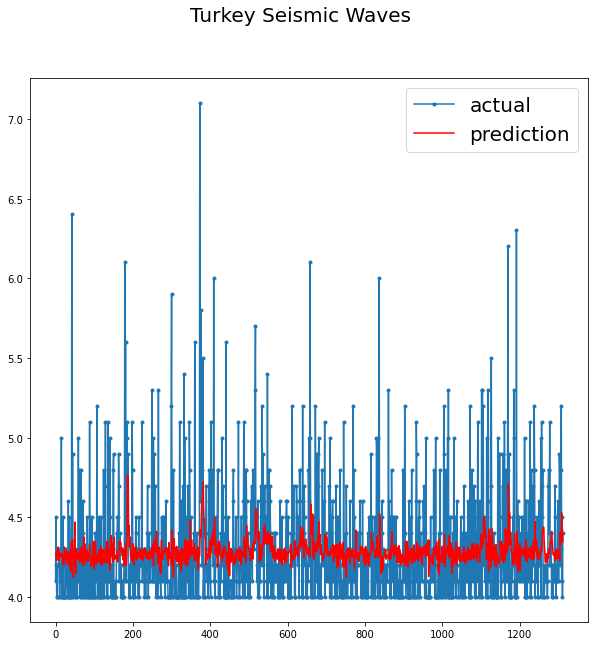

In [11]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = [10, 10] # for square canvas
plt.plot(inv_y, marker='.', label="actual")
plt.plot(inv_yhat, 'r', label="prediction")
plt.suptitle('Turkey Seismic Waves', fontsize=20)
plt.legend(fontsize=20)
plt.show()